## Principal Component Analysis (PCA)

PCA has become a popular tool in financial engineering and machine learning. 

Wikipedia describes PCA as follows:

*Principal component analysis (PCA) is a statistical procedure that uses orthogonal transformation
to convert a set of observations of possibly correlated variables into a set of
values of linearly uncorrelated variables called principal components. The number of
principal components is less than or equal to the number of original variables. This
transformation is defined in such a way that the first principal component has the largest
possible variance (that is, accounts for as much of the variability in the data as possible),
and each succeeding component in turn has the highest variance possible under the
constraint that it is orthogonal to (i.e., uncorrelated with) the preceding components.*

In this tutorial we use PCA to decompose the Dow Jones Industrial average into a set of components that nearly perfectly spans the same stochastic process as the original market index. One can think of these components as linear combinations, i.e. sub-portfolios, of a few selected stocks from the original portfolio. The set of principal components serve as the `pca_index`.

### Constructing the Data Set

Below we import the 30 constituents of the Dow Jones Industrial Average (DJI). DJI is an equally weighted index of the 30 constituents and thus is simple to reconstruct as we do below. 

In [186]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import pandas_datareader as pdr
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt

In [157]:
ticker_list = ['MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DOW', 'GS', 'HD', 
               'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV',
               'UNH', 'VZ', 'V', 'WBA', 'WMT', 'DIS']
market = []
for i in ticker_list:
    df_1 = pdr.DataReader(i, 'yahoo', 2020, 2021)
    df_1['ticker'] = i
    market.append(df_1)
market = pd.concat(market)

market = market.pivot(columns='ticker', values='Close')
market.dropna(axis=0, inplace=True)

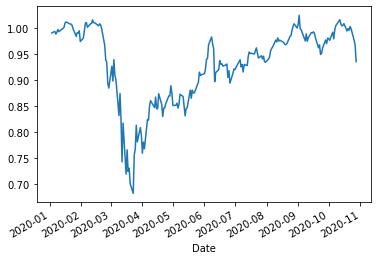

In [165]:
market['^DJI'] = market.pct_change().mean(axis=1) +1
market['^DJI'].cumprod().plot()

### Applying PCA

For geometric reasons, the first step when applying PCA is to center your data to zero mean and unit standard deviation. The reason for this is that now the $L^2$-norm and Euclidian geometry can be applied in the data set as we establish a link between angles and correlations. The details are beyond the scope of this tutorial, but as the PCA aims at producing orthogonal components, for centered random variables in $L^2$-space independence and orthogonality coincide.    

In [166]:
scale_function = lambda x: (x - x.mean()) / x.std()
pca = KernelPCA().fit(market.drop('^DJI', axis=1).apply(scale_function))

The magnitude of the explanatory power of each component is given by its Eigenvalue. These are conveniently found as an attribute in the `KernelPCA` object.

Below we plot the explanatory power of 30 principal components in a bar-lot depicting how fast the Eigenvalues decay. 

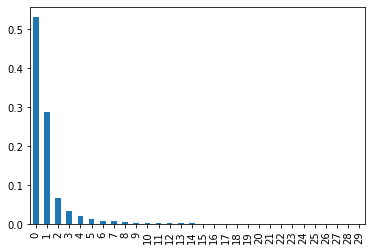

In [167]:
pd.Series(pca.lambdas_/pca.lambdas_.sum()).plot.bar()

In [170]:
pd.Series(pca.lambdas_/pca.lambdas_.sum()).loc[:4].sum()

0.9412894823884321

The first component explains close to 53% of the variation of the data set, and the first five components explain close to 95% of the variation of the data set. With this, we have the confidence to choose the top 5 components to work with. 

### Constructing a PCA Factor Index

We proceed to construct a PCA factor index to track the original DJI stock market index. Let us see how well we are able to approximate the DJI with the first principal component. 

,^DJI,pca_1
^DJI,1.00,0.94
pca_1,0.94,1.00


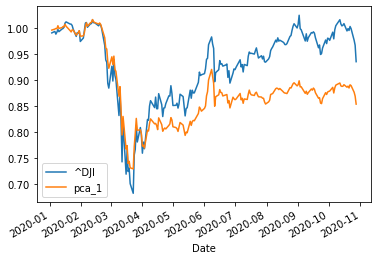

In [181]:
pca_1 = KernelPCA(n_components=1).fit(market.drop('^DJI', axis=1))#.apply(scale_function))
pca_1 = pd.DataFrame(pca_1.transform(-market.drop('^DJI', axis=1)), 
                     columns=['pca_1'], 
                     index=market.index)

df = pd.concat([market[['^DJI']], (pca_1.pct_change()+1)], axis=1)
(df).cumprod().plot()
df.corr().round(2)

As we see, the first principal component captures the crash over February and March of 2020, as well as the general trend. The correlation between the two is high, 94%. We cannot expect the additional components to add too much, however we can expect to arrive close to 100% correlation via additional components.

We proceed by adding the top five components and studying how this effects the PCA factor index. We construct the index by weighting each component with a weight derived from the Eigenvalue, i.e. corresponding to the components relative explanatory power.

In [197]:
pca_5 = KernelPCA(n_components=5).fit(market.drop('^DJI', axis=1).apply(scale_function))
w = pd.Series(pca_5.lambdas_/pca_5.lambdas_.sum(), index=['pca_1', 'pca_2','pca_3','pca_4','pca_5'])
pca_5 = pd.DataFrame(pca_5.transform(-market.drop('^DJI', axis=1)),
                     columns=['pca_1', 'pca_2','pca_3','pca_4','pca_5'], 
                     index=market.index)
pca_5 = pca_5.dot(w).rename('pca_5')
df_5 = pd.concat([market[['^DJI']], (pca_5.pct_change()+1)], axis=1)

,^DJI,pca_5
^DJI,1.00,0.98
pca_5,0.98,1.00


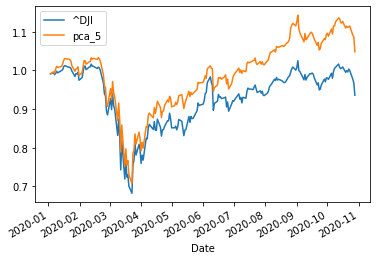

In [198]:
(df_5).cumprod().plot()
df_5.corr().round(2)

As we see, the correlation increased by 4% from 94% to 98% as we introduced 4 additional principal components into the factor portfolio. This is a great improvement in the sense that we are able to replicate close to 100% of the variance of the market index.  

It is interesting to notice that the pca_5 index seems to be approximating the market index extremely closely until the end of April of 2020. As a matter of fact, we should be able to plot the values in a scatterplot, using dates as an extra dimension represented by color, to see when the values diverge from a least-squares regression line between the two series. 

We proceed by converting the `pandas` datetime data-structures into `matplotlib` format. We will then plot the scatterplot and fit a regression line into the point-cloud. This will indeed highlight how things over time.

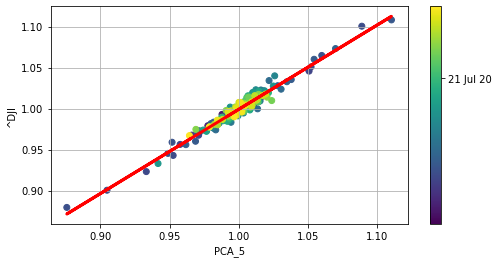

In [204]:
df_5.dropna(axis=0, inplace=True)
mpl_dates = mpl.dates.date2num(df_5.index)

plt.figure(figsize=(8, 4))
plt.scatter(df_5['pca_5'], df_5['^DJI'], c=mpl_dates)
lin_reg = np.polyval(np.polyfit(df_5['pca_5'], 
                                df_5['^DJI'], 1), 
                                df_5['pca_5'])
plt.plot(df_5['pca_5'], lin_reg, 'r', lw=3)
plt.grid(True)
plt.xlabel('PCA_5')
plt.ylabel('^DJI')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
format=mpl.dates.DateFormatter('%d %b %y'))

As we see, the correlation is strongest during the first part of the year and decays a bit towards the end of the year. This indicates that there is a structural change as we approach the bottom of the downturn and continue to recover.

This tutorial gave an insight into how PCA works and how we can analyze the structure of a given data set using PCA and regression analysis. A future extension of the analysis would be to use Independent Component Analysis (ICA) and study the connection between PCA and ICA from a structural perspective 